# Next Gen Stats - Targeted Route Analysis

## Set up

In [1]:
#Import your libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib as mpl
from scipy import stats
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#Make prettier graphs
%config InlineBackend.figure_format = 'retina'

In [2]:
#Load in the data
route_locations = pd.read_csv('route_and_game_data.csv')

In [3]:
#Quick look at the data
route_locations.head(3)

,Unnamed: 0,game_id,team,week,name,position,route_type,x_coord,y_coord,type,home_team,away_team,season,game_url,home_score,away_score
0,1,2019090809,ARI,1.0,Larry Fitzgerald,WR,COMPLETE,-26.1,45.2,reg,ARI,DET,2019,http://www.nfl.com/liveupdate/game-center/2019...,27,27
1,2,2019090809,ARI,1.0,Larry Fitzgerald,WR,COMPLETE,-26.1,45.2,reg,ARI,DET,2019,http://www.nfl.com/liveupdate/game-center/2019...,27,27
2,3,2019090809,ARI,1.0,Larry Fitzgerald,WR,COMPLETE,-26.1,45.2,reg,ARI,DET,2019,http://www.nfl.com/liveupdate/game-center/2019...,27,27


## Data cleaning/Formatting

In [4]:
#Get the number of games (or charts) for each receiver, 
#using two groupby functions (likely a more efficient way out there), so we
#know how many games we're working with for each receiver
games = route_locations.groupby(by=['name','game_id'])['x_coord','y_coord'].mean()
player_games = games.groupby(by=['name'])['x_coord','y_coord'].count()
player_games.reset_index(inplace=True)
player_games.columns = ['name','games_played','na']
#Merge this new games dataframe with the original route locations
route_locations = pd.merge(route_locations,player_games, how='inner', on='name')

## Kernel Density Estimate

In [5]:
#Helper function for our kernal density estimates
def kde_helper(m1,m2):
    '''Function to get data in the correct form for the KDE function
    inputs: x_data, y_data, # of spaces for mesh grid
    output: KDE applied to mesh grid, ready for plotting,
    along with the boundaries of the data '''
    #Set boundaries
    xmin = m1.min()
    xmax = m1.max()
    ymin = m2.min()
    ymax = m2.max()
    #Creating a mesh grid dividing each yard in half (so 4 units in a square yard),
    #between the boundaries of the x and y coordinates (values we care about) supplied
    #By using the same size grid each time, all our outputs will sum to the same 
    #number (4, as they integrate to 1 and the field is divided into 4ths)
    #this way, we can compare apples to apples
    X, Y = np.mgrid[-30:30:121j, -10:55:131j]
    #Unravel and stack these grids, giving a 2xn array of positions, where n = ^2
    positions = np.vstack([X.ravel(), Y.ravel()])
    #Stack the values we care about in a 2xn array
    values = np.vstack([m1, m2])
    #Perform the kernel estimation on the values we care about
    kernel = stats.gaussian_kde(values)
    #Generate probabilities at the positions specified, transpose them, and put them back into the grid shape for plotting
    Z = np.reshape(kernel(positions).T, X.shape)
    return Z, xmin, xmax, ymin, ymax

In [6]:
#here we only care about the precatch portion of the route - so no YAC route types
route_locations = route_locations.loc[(route_locations['route_type']!='YAC')]

### Select your player

In [11]:
#pick the WR you want to graph
wr_name = 'player_name'
wr = route_locations.loc[(route_locations['name'].str.contains(wr_name))]

In [12]:
%%time

#Get data
x = wr.loc[(wr['x_coord'].notnull())]
y = wr.loc[(wr['y_coord'].notnull())]
x=x['x_coord']
y=y['y_coord']
#Run function
wr_kde, xmin, xmax, ymin, ymax = kde_helper(x,y)

Wall time: 9.03 s


### Plotting

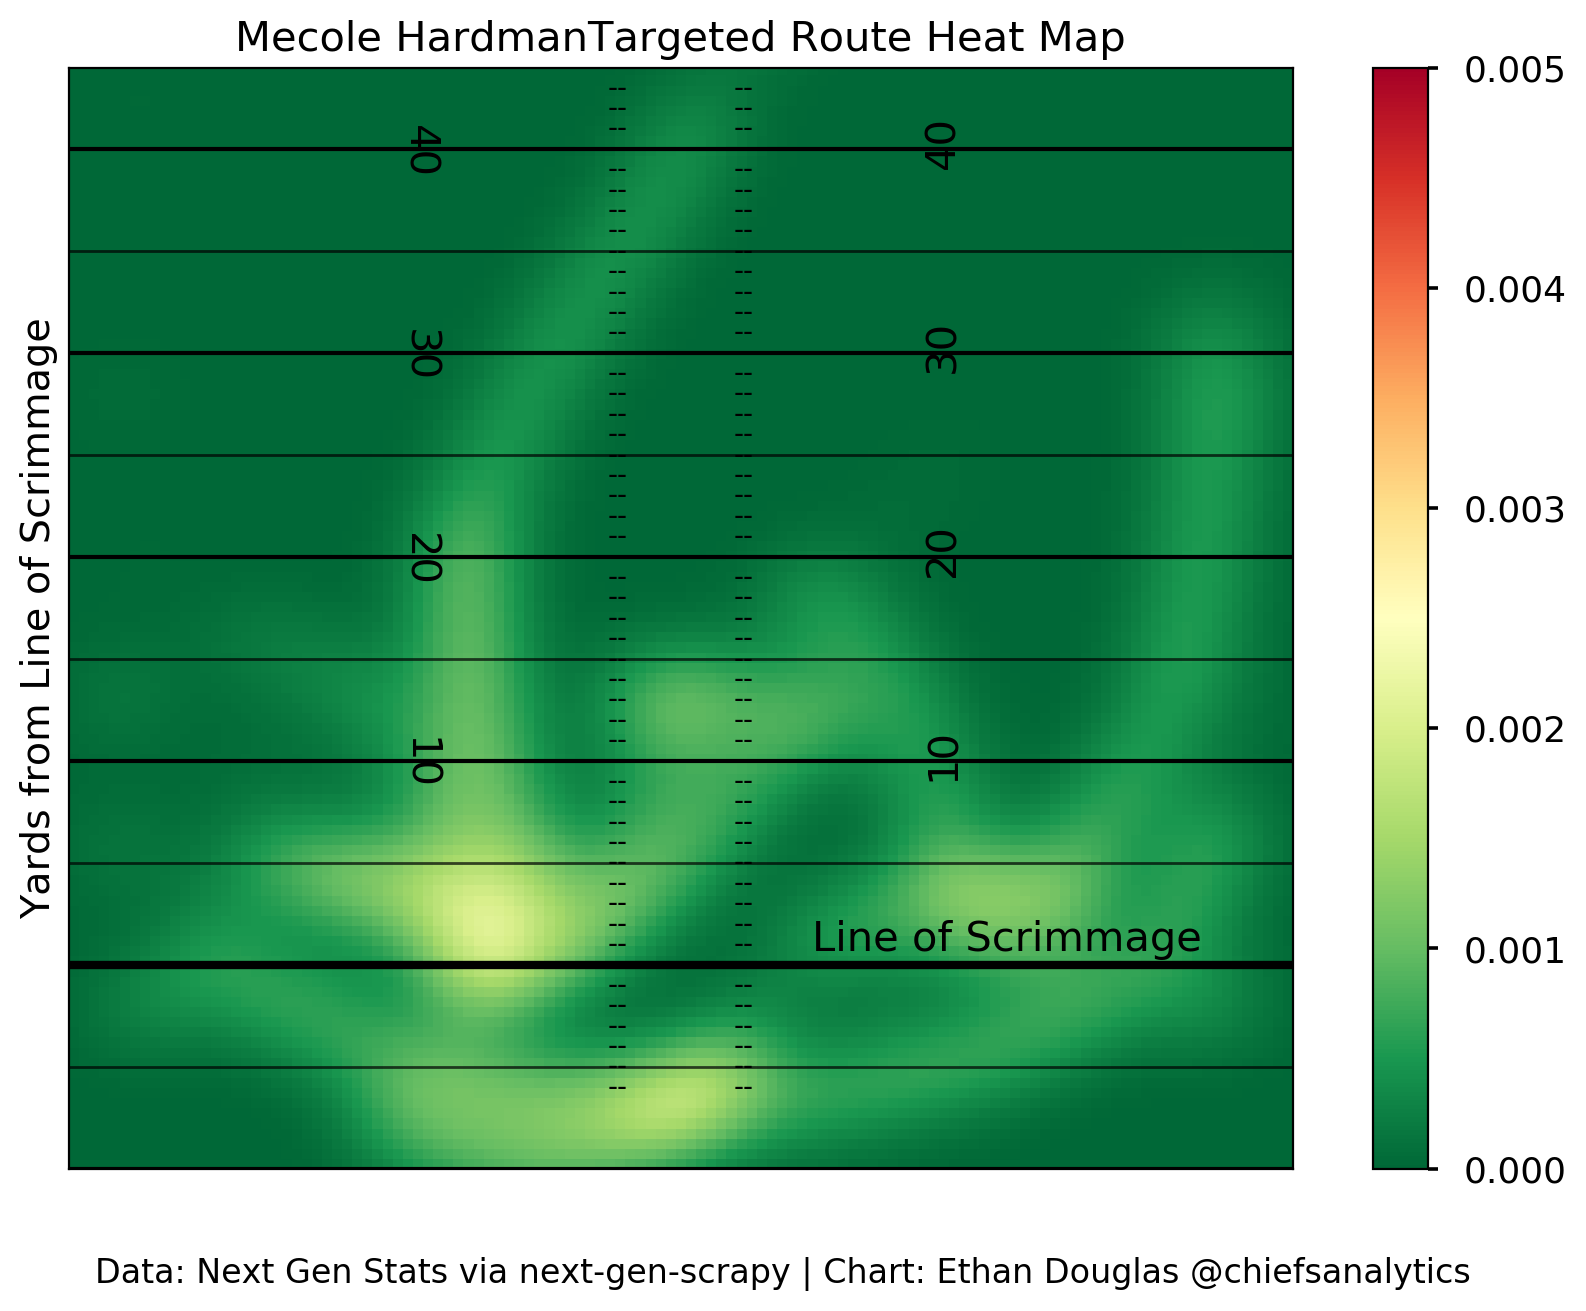

In [13]:

#Using my favorite plotting style, seaborn-talk
plt.style.use('default')
plt.style.use('seaborn-talk')

xmin2 = -30
xmax2 = -1*xmin2
ymin2 = -10
ymax2 = 55

#This sets the max and min inline with what our data boundary is, 
#so we aren't stretching or shrinking the image at all
plt.imshow(np.fliplr(np.rot90(wr_kde,3)),
           origin='lower', aspect='equal',
           extent=[xmin2, xmax2, ymin2, ymax2],
           norm = mpl.colors.Normalize(vmin=0., vmax=0.005),
           cmap='RdYlGn_r')


#now we set the limits we actually want for our plot
#I think 44 yards is a good upper limit, but do what you wish
xmin2 = -30
xmax2 = -1*xmin2
ymin2 = -10
ymax2 = 44

cbar = plt.colorbar()
# cbar.set_label("Route Density")

#Axis limits
plt.xlim([xmin2,xmax2])
plt.ylim([ymin2, ymax2])
#Y-axis label
plt.ylabel('Yards from Line of Scrimmage')
#Get rid of ticks
plt.xticks([])
plt.yticks([])

#Annotations
plt.axhline(0,c='k',ls='-',alpha=1,lw=3)

for j in range(-7,ymax2-1,1):
    plt.annotate('--', (-3.1,j-0.1),
                 textcoords="offset points",
                 xytext=(0,5),
                 ha='center',fontsize =10)
    plt.annotate('--', (3.1,j-0.1),
                 textcoords="offset points",
                 xytext=(0,5),
                 ha='center',fontsize =10)
    
for i in range(-10,ymax2,5):
    plt.axhline(i,c='k',ls='-',alpha=0.7, lw=1)
    
for i in range(-10,ymax2,10):
    plt.axhline(i,c='k',ls='-',alpha=1, lw=1.5)
    
for i in range(10,ymax2-1,10):
    plt.annotate(str(i), (-12.88,i-1.65),
            textcoords="offset points",
            xytext=(0,5),
            ha='center',fontsize =15,
                rotation=270)
    plt.annotate(str(i), (12.88,i-1.2),
            textcoords="offset points",
            xytext=(0,5),
            ha='center',fontsize =15,
                rotation=90)
 
plt.annotate('Line of Scrimmage', (16,0),
             textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center',fontsize = 15) # horizontal alignment can be left, right or center
#Final touches
title = wr_name + 'Targeted Route Heat Map'
plt.title(title,fontsize=15)
#If you make changes to the chart of course feel free to delete the chart template attribution,
#but please credit NGS and next-gen-scrapy for the data in any uses
txt="Data: Next Gen Stats via next-gen-scrapy2.0 | Chart Template: @chiefsanalytics"
plt.figtext(0.5, 0.03, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()